# Resonate and Fire neurons

Here I am trying to recreate experiments from Eugene M. Izhikevich's paper: https://www.izhikevich.org/publications/resfire.htm

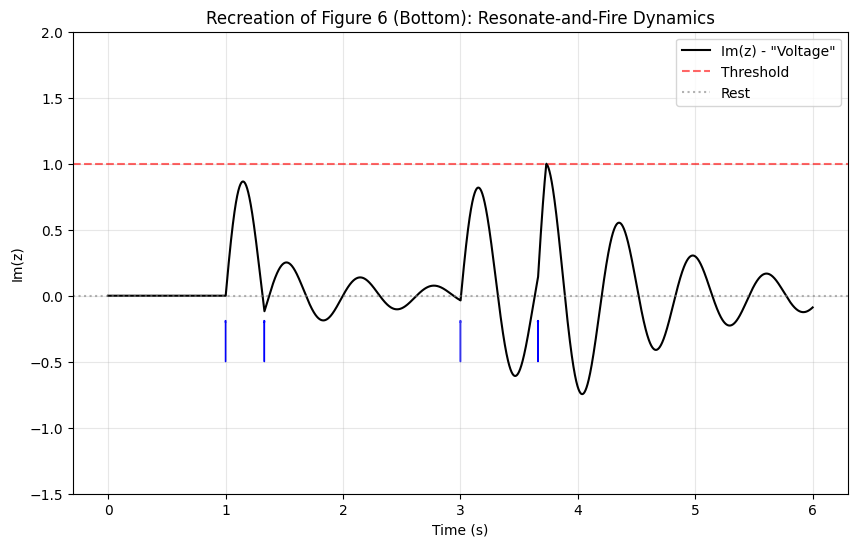

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def resonate_and_fire_simulation():
    # --- Parameters from Izhikevich 2001 ---
    # "We use b = -1 and omega = 10 in most of our illustrations" [cite: 159]
    b = -1.0 
    omega = 10.0
    dt = 0.001       # 1ms time step (Simulating small delta)
    threshold = 1.0  # Firing threshold for Im(z) 
    reset_val = 0 + 1j # Reset to i 
    
    # Simulation duration
    time = np.arange(0, 6, dt) # 0.6 seconds
    z = np.zeros_like(time, dtype=complex)
    
    # Input Pulses (matches Fig 6 pulses roughly)
    # We add pulses at t=0.1s and t=0.3s approx
    I = np.zeros_like(time)
    pulse_strength = 1000.0 # Arbitrary strength to cause a jump in discrete time
    
    # Add two pulses
    pulse_indices = [int(1/dt), int(1.33/dt), int(3/dt), int(3.66/dt)]
    for idx in pulse_indices:
        I[idx] = pulse_strength

    # --- Simulation Loop (Euler Integration) ---
    spikes = []
    
    for t in range(1, len(time)):
        # 1. Calculate Derivative: dz/dt = (b + iw)z + Input
        # Note: Input I typically affects the Real part (Current) [cite: 157]
        dz = (b + 1j * omega) * z[t-1] + I[t-1]
        
        # 2. Update State
        z[t] = z[t-1] + dz * dt
        
        # 3. Check Threshold (Im(z) > 1)
        if z[t].imag > threshold:
            z[t] = reset_val # Reset logic
            spikes.append(time[t])
            # Optional: In plots, we often clip the spike for visual cleanliness
            # but biologically it resets.

    # --- Plotting to Match Figure 6 ---
    plt.figure(figsize=(10, 6))
    
    # Plot Real and Imaginary parts
    # The paper plots Im(z) as the "Voltage-like" variable 
    plt.plot(time, z.imag, 'k-', linewidth=1.5, label='Im(z) - "Voltage"')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.6, label='Threshold')
    plt.axhline(y=0.0, color='gray', linestyle=':', alpha=0.6, label='Rest')
    
    # Visualize Pulses
    for t_pulse in np.array(pulse_indices)*dt:
        plt.arrow(t_pulse, -0.5, 0, 0.3, width=0.002, head_width=0.01, color='blue', label='Input Pulse' if t_pulse==0.1 else "")

    plt.title("Recreation of Figure 6 (Bottom): Resonate-and-Fire Dynamics")
    plt.xlabel("Time (s)")
    plt.ylabel("Im(z)")
    plt.ylim(-1.5, 2.0)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

resonate_and_fire_simulation()

Sweeping distances up to 15.0m...


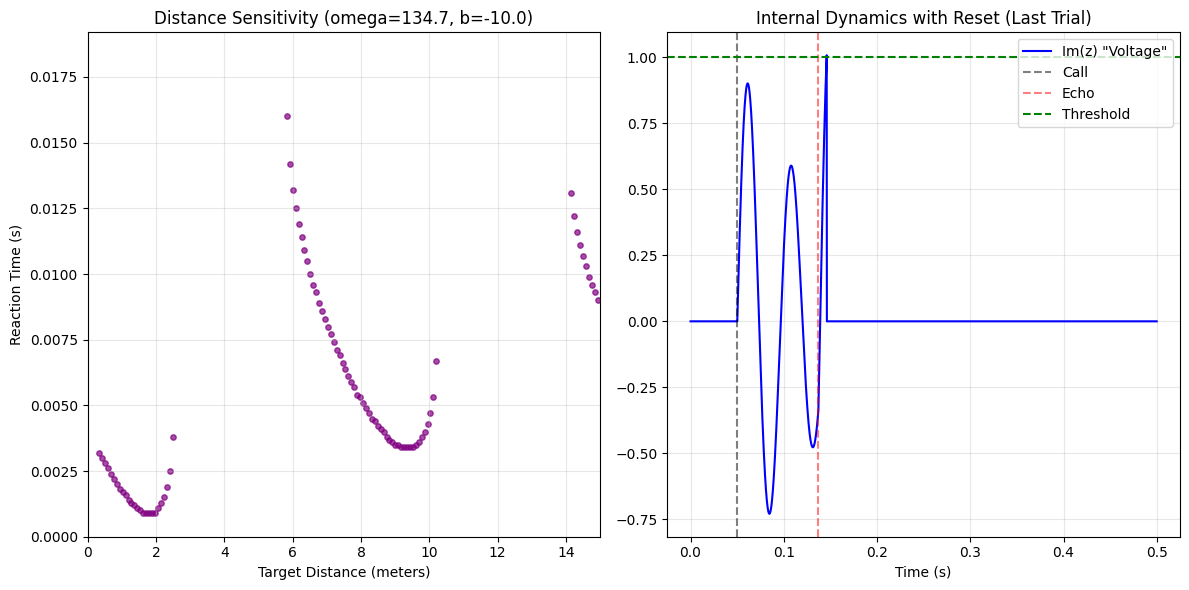

In [89]:
import numpy as np
import matplotlib.pyplot as plt

def run_experiment_with_reset():
    # --- Physical Constants ---
    SPEED_OF_SOUND = 343.0  # m/s
    
    # --- Neuron Parameters ---
    b = -10.0       # High damping (precision mode)
    omega = 134.7   # Tuned for approx 2.0 meters
    dt = 0.0001     # Time step
    threshold = 1.0 # Firing threshold
    
    # Pulse Strength
    pulse_strength = 1.0/dt  
    
    # --- Experiment Setup ---
    max_distance = 15.0
    max_delay = (max_distance * 2) / SPEED_OF_SOUND
    delays = np.arange(0.002, max_delay, 0.0005) 
    
    successful_distances = []
    response_times = []
    
    print(f"Sweeping distances up to {max_distance}m...")

    # --- MAIN DATA LOOP ---
    # (This gathers the dots for Plot 1)
    for delay_val in delays:
        duration = 0.5 
        time = np.arange(0, duration, dt)
        
        # Create Inputs
        I = np.zeros_like(time)
        t_pulse1 = 0.05
        idx1 = int(t_pulse1 / dt)
        I[idx1] = pulse_strength
        
        idx2 = idx1 + int(delay_val / dt)
        if idx2 < len(time):
            I[idx2] = pulse_strength
        
        # Dynamics
        curr_z = 0 + 0j
        fired = False
        spike_time = None
        
        for t in range(1, len(time)):
            dz = (b + 1j * omega) * curr_z + I[t-1]
            curr_z = curr_z + dz * dt
            
            if curr_z.imag > threshold:
                fired = True
                spike_time = time[t]
                # In the data loop, we break immediately because we just need 
                # the "First Spike" time.
                break 
        
        if fired:
            if spike_time > (t_pulse1 + delay_val):
                dist = (SPEED_OF_SOUND * delay_val) / 2
                successful_distances.append(dist)
                response_times.append(spike_time - (t_pulse1 + delay_val))

    # --- PLOTTING ---
    plt.figure(figsize=(12, 6))
    
    # Plot 1: The Tuning Curve
    plt.subplot(1, 2, 1)
    if len(successful_distances) > 0:
        plt.scatter(successful_distances, response_times, c='purple', s=15, alpha=0.7)
    
    plt.xlim(0, max_distance)
    plt.ylim(0, max(response_times)*1.2 if len(response_times) > 0 else 0.1)
    plt.title(f"Distance Sensitivity (omega={omega}, b={b})")
    plt.xlabel("Target Distance (meters)")
    plt.ylabel("Reaction Time (s)")
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Internal Dynamics WITH RESET
    plt.subplot(1, 2, 2)
    
    # NOTE: We rely on 'I' and 'delay_val' from the LAST iteration of the loop above.
    # This shows the dynamics for the furthest distance tested.
    
    z_vis = np.zeros_like(time, dtype=complex)
    curr_z = 0+0j
    
    # --- UPDATED VISUALIZATION LOOP ---
    for t in range(1, len(time)):
        dz = (b + 1j * omega) * curr_z + I[t-1]
        curr_z = curr_z + dz * dt
        
        # 1. Save the state FIRST (so we capture the peak of the spike)
        z_vis[t] = curr_z
        
        # 2. Check Threshold & Reset
        if curr_z.imag > threshold:
            # Mechanically reset the internal state to "Rest"
            curr_z = 0 + 0j 
            
            # Optional: Visual flair - cap the plot value at threshold or leave as is.
            # Leaving it as is shows the "overshoot" before the reset.
    
    plt.plot(time, z_vis.imag, 'b-', label='Im(z) "Voltage"')
    plt.axvline(t_pulse1, color='k', linestyle='--', alpha=0.5, label='Call')
    plt.axvline(t_pulse1 + delay_val, color='r', linestyle='--', alpha=0.5, label='Echo')
    plt.axhline(threshold, color='g', linestyle='--', label='Threshold')
    
    plt.title(f"Internal Dynamics with Reset (Last Trial)")
    plt.xlabel("Time (s)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

run_experiment_with_reset()

Sweeping distances up to 15.0m...


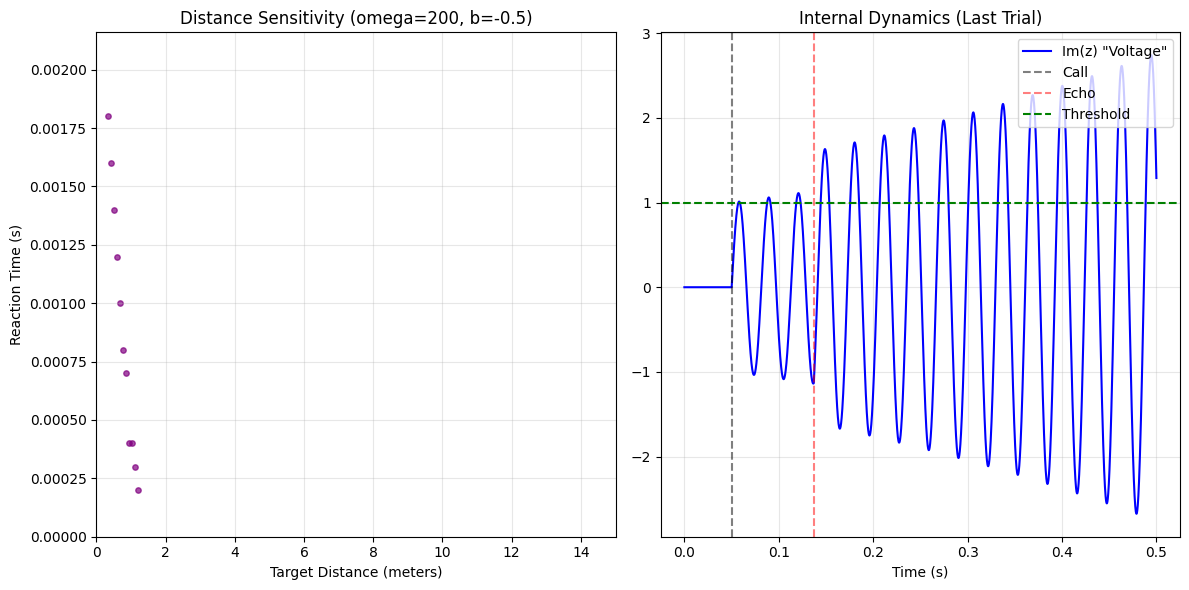

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def run_experiment_sweep():
    # --- Physical Constants ---
    SPEED_OF_SOUND = 343.0  # m/s
    
    # --- Neuron Parameters ---
    # b: Controls how fast the "memory" fades. 
    # Set to -0.5 to allow ringing for ~100-200ms.
    b = -0.5       
    
    # omega: Controls the "Pitch" of the neuron's listening frequency.
    # Higher omega = Short distance detector (fast ringing)
    # Lower omega = Long distance detector (slow ringing)
    omega = 200   
    
    dt = 0.0001     # 0.5ms time step
    threshold = 1.0 # Firing threshold
    
    # Pulse Strength:
    # Must be enough to start ringing, but NOT enough to fire on the first pulse alone.
    pulse_strength = 1/dt  
    
    # --- Experiment Setup ---
    # Max distance we want to test (e.g., 50 meters)
    max_distance = 15.0
    max_delay = (max_distance * 2) / SPEED_OF_SOUND
    
    # Sweep delays from near-zero to max_delay
    delays = np.arange(0.002, max_delay, 0.0005) 
    
    successful_distances = []
    response_times = []
    
    print(f"Sweeping distances up to {max_distance}m...")

    for delay_val in delays:
        # Duration: Pulse 1 time + Max Delay + Buffer
        duration = 0.5 
        time = np.arange(0, duration, dt)
        
        # --- Create Inputs ---
        I = np.zeros_like(time)
        
        # Pulse 1: The "Call" happens at 50ms (0.05s) to give some settling time
        t_pulse1 = 0.05
        idx1 = int(t_pulse1 / dt)
        I[idx1] = pulse_strength
        
        # Pulse 2: The "Echo" happens at t_pulse1 + delay
        idx2 = idx1 + int(delay_val / dt)
        
        if idx2 < len(time):
            I[idx2] = pulse_strength
        
        # --- Dynamics Loop ---
        fired = False
        spike_time = None
        
        # Start at REST (0,0), not at Threshold (0,1)
        curr_z = 0 + 0j
        
        for t in range(1, len(time)):
            # Izhikevich Resonate-and-Fire Dynamics
            dz = (b + 1j * omega) * curr_z + I[t-1]
            curr_z = curr_z + dz * dt
            
            # Check Threshold
            if curr_z.imag > threshold:
                fired = True
                spike_time = time[t]
                break # Stop after first spike for this test
        
        # --- Data Collection ---
        if fired:
            # We only care if it fired AFTER the echo arrived
            # (Constructive interference)
            if spike_time > (t_pulse1 + delay_val):
                dist = (SPEED_OF_SOUND * delay_val) / 2
                successful_distances.append(dist)
                
                # Latency: Time between Echo Arrival and Firing
                response_times.append(spike_time - (t_pulse1 + delay_val))

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    
    # Plot 1: The Tuning Curve
    plt.subplot(1, 2, 1)
    if len(successful_distances) > 0:
        plt.scatter(successful_distances, response_times, c='purple', s=15, alpha=0.7)
    
    # 1. FIXED X-AXIS: Force it to show 0 to Max Distance
    plt.xlim(0, max_distance)
    plt.ylim(0, max(response_times)*1.2 if len(response_times) > 0 else 1)
    
    plt.title(f"Distance Sensitivity (omega={omega}, b={b})")
    plt.xlabel("Target Distance (meters)")
    plt.ylabel("Reaction Time (s)")
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Single Trial Dynamics (Show a successful one)
    plt.subplot(1, 2, 2)
    
    # Visualization run
    z_vis = np.zeros_like(time, dtype=complex)
    curr_z = 0+0j
    for t in range(1, len(time)):
        dz = (b + 1j * omega) * curr_z + I[t-1]
        curr_z = curr_z + dz * dt
        z_vis[t] = curr_z
        
    plt.plot(time, z_vis.imag, 'b-', label='Im(z) "Voltage"')
    plt.axvline(t_pulse1, color='k', linestyle='--', alpha=0.5, label='Call')
    # Show where the echo is for the LAST loop iteration
    plt.axvline(t_pulse1 + delay_val, color='r', linestyle='--', alpha=0.5, label='Echo')
    plt.axhline(threshold, color='g', linestyle='--', label='Threshold')
    
    plt.title(f"Internal Dynamics (Last Trial)")
    plt.xlabel("Time (s)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

run_experiment_sweep()

## Tuning the Resonate-and-Fire Neuron: Mathematical Derivation

To tune a **Balanced Resonate-and-Fire (BRF)** neuron to detect a specific target distance, we must align the neuron's internal resonant frequency ($\omega$) with the round-trip time of the echo.

### 1. The Physical Relationship
The relationship between distance and time is governed by the speed of sound ($c$):

$$t_{echo} = \frac{2 \cdot D}{c}$$

* $t_{echo}$: Time delay between the pulse and the echo (seconds).
* $D$: Distance to the target (meters).
* $c$: Speed of sound ($\approx 343 \text{ m/s}$).

### 2. The Resonance Condition
The neuron's internal state $z$ oscillates according to the equation $z(t) = e^{(b + i\omega)t}$. The imaginary component (voltage) behaves like a damped sine wave:

$$V(t) \propto e^{bt} \sin(\omega t)$$

For **Constructive Interference** to occur, the second pulse (echo) must arrive exactly when the oscillation from the first pulse reaches a peak. The first positive peak of a sine wave occurs at $\frac{\pi}{2}$ radians ($90^{\circ}$), or $\frac{1}{4}$ of a full cycle.

Therefore, we set the echo delay equal to the time of the first peak:

$$\omega \cdot t_{echo} \approx \frac{\pi}{2}$$

### 3. The Tuning Formula
Substituting the physical time delay ($t_{echo}$) into the resonance condition:

$$\omega \cdot \left( \frac{2D}{c} \right) = \frac{\pi}{2}$$

Solving for $\omega$ (the angular frequency parameter in the code):

$$\omega = \frac{\pi \cdot c}{4 \cdot D}$$

---

### Example Calculation

**Scenario:** You want to tune a neuron to detect a moth at **2.0 meters**.

1.  **Given:**
    * $c = 343 \text{ m/s}$
    * $D = 2.0 \text{ m}$

2.  **Calculate:**
    $$\omega = \frac{3.14159 \times 343}{4 \times 2.0}$$
    $$\omega = \frac{1077.56}{8}$$
    $$\omega \approx 134.7$$

**Result:** Setting `omega = 134.7` in the code will create a sensitivity band peaking at exactly 2 meters.

---

### Why Multi-Harmonic Bands Appear
You will see secondary bands of sensitivity at further distances. This happens because a sine wave peaks periodically ($\frac{\pi}{2}, \frac{5\pi}{2}, \frac{9\pi}{2} \dots$).

The general formula for all valid distances for a single $\omega$ is:

$$D_n = \frac{c \cdot (4n + 1)\pi}{4\omega} \quad \text{for } n = 0, 1, 2 \dots$$

* $n=0$: The primary target distance (strongest response).
* $n=1$: The second "harmonic" distance (weaker due to damping $b$).

Simulating Latency Map (Log Scale)...


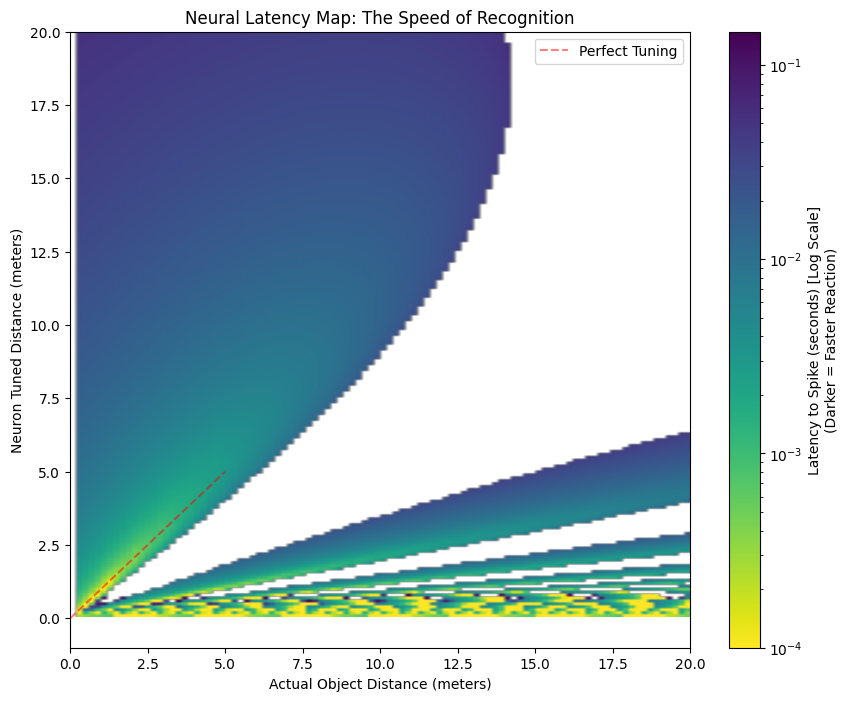

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # <--- Import LogNorm

def run_latency_heatmap_log():
    # --- 1. Physical Constants ---
    SPEED_OF_SOUND = 343.0
    
    # --- 2. Simulation Settings ---
    dt = 0.0001  
    b = -5    
    pulse_strength = 1/dt
    threshold = 1.0
    
    # Range of Neurons (Y-Axis)
    num_neurons = 200
    preferred_distances = np.linspace(0.05, 20.0, num_neurons)
    omegas = (np.pi * SPEED_OF_SOUND) / (4 * preferred_distances)
    
    # Range of Object Distances (X-Axis)
    test_distances = np.linspace(0.0, 20.0, 100)
    
    # Heatmap Matrix: Initialize with NaN (for transparent background)
    latency_map = np.full((num_neurons, len(test_distances)), np.nan)
    
    print(f"Simulating Latency Map (Log Scale)...")
    
    # --- 3. The Big Loop ---
    for n_idx, omega in enumerate(omegas):
        for d_idx, dist_val in enumerate(test_distances):
            
            delay_val = (dist_val * 2) / SPEED_OF_SOUND
            if delay_val < dt: continue

            duration = 0.05 + delay_val + 0.15 
            time = np.arange(0, duration, dt)
            
            I = np.zeros_like(time)
            
            # Pulse 1 (Call)
            t_pulse1 = 0.05
            idx1 = int(t_pulse1 / dt)
            I[idx1] = pulse_strength
            
            # Pulse 2 (Echo)
            t_echo_arrival = t_pulse1 + delay_val
            idx2 = idx1 + int(delay_val / dt)
            if idx2 < len(time):
                I[idx2] = pulse_strength
            
            # Dynamics
            curr_z = 0 + 0j
            fired = False
            spike_time = 0
            
            for t in range(1, len(time)):
                dz = (b + 1j * omega) * curr_z + I[t-1]
                curr_z = curr_z + dz * dt
                
                if curr_z.imag > threshold:
                    if time[t] >= t_echo_arrival:
                        fired = True
                        spike_time = time[t]
                        break 
            
            if fired:
                # Calculate Latency
                latency_val = spike_time - t_echo_arrival
                
                # Safety: Ensure latency is strictly positive for Log Plot
                # (If latency is 0, we set it to dt/10)
                if latency_val <= 0:
                    latency_val = dt / 10
                    
                latency_map[n_idx, d_idx] = latency_val

    # --- 4. Plotting ---
    plt.figure(figsize=(10, 8))
    
    # Use LogNorm for the logarithmic color scaling
    # We set vmin to 'dt' so the scale starts at the fastest possible resolution step
    im = plt.imshow(latency_map, aspect='auto', origin='lower', cmap='viridis_r',
               norm=LogNorm(vmin=dt, vmax=np.nanmax(latency_map)), # <--- Log Scale applied here
               extent=[test_distances[0], test_distances[-1], preferred_distances[0], preferred_distances[-1]])
    
    cbar = plt.colorbar(im)
    cbar.set_label("Latency to Spike (seconds) [Log Scale]\n(Darker = Faster Reaction)")
    
    plt.title("Neural Latency Map: The Speed of Recognition")
    plt.xlabel("Actual Object Distance (meters)")
    plt.ylabel("Neuron Tuned Distance (meters)")
    
    # Add the diagonal guide
    plt.plot([0, 5], [0, 5], 'r--', alpha=0.5, label='Perfect Tuning')
    
    plt.legend()
    plt.show()

run_latency_heatmap_log()

Simulating Log-Space Map...


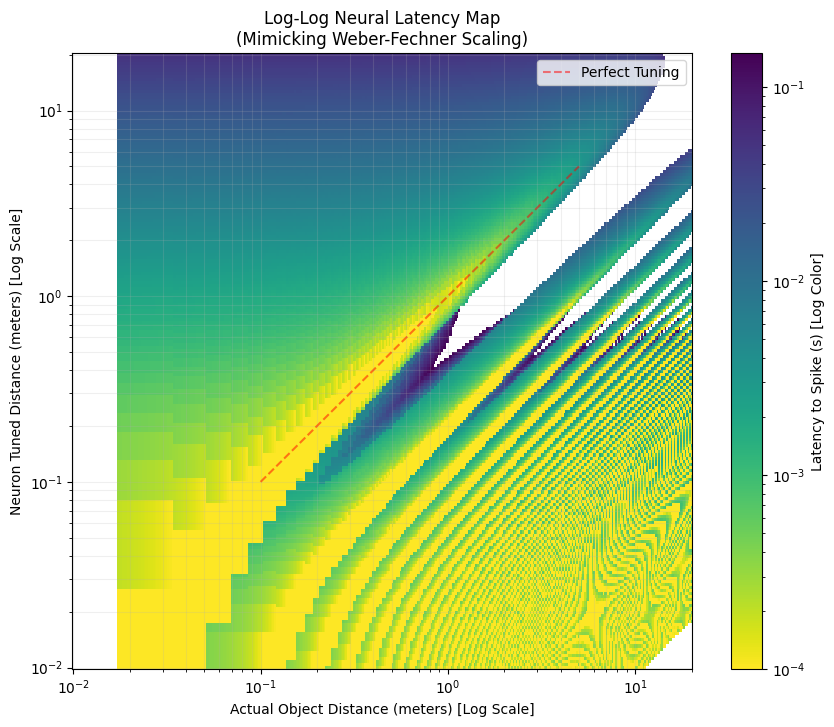

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def run_latency_heatmap_log_axes():
    # --- 1. Physical Constants ---
    SPEED_OF_SOUND = 343.0
    
    # --- 2. Simulation Settings ---
    dt = 0.0001  
    b = -5    
    pulse_strength = 1/dt
    threshold = 1.0
    
    # --- Logarithmic Sampling ---
    # We use geomspace to create spacing that is uniform on a log scale.
    # This places more neurons at short distances (high precision) 
    # and fewer at long distances (low precision).
    
    num_neurons = 200
    # Tune neurons from 10cm (0.1m) to 5m
    preferred_distances = np.geomspace(0.01, 20.0, num_neurons)
    
    # Tuning Logic (Same formula)
    omegas = (np.pi * SPEED_OF_SOUND) / (4 * preferred_distances)
    
    # Test Objects: Logarithmically spaced from 10cm to 6m
    test_distances = np.geomspace(0.01, 20.0, 400)
    
    # Heatmap Matrix
    latency_map = np.full((num_neurons, len(test_distances)), np.nan)
    
    print(f"Simulating Log-Space Map...")
    
    # --- 3. The Big Loop ---
    for n_idx, omega in enumerate(omegas):
        for d_idx, dist_val in enumerate(test_distances):
            
            delay_val = (dist_val * 2) / SPEED_OF_SOUND
            if delay_val < dt: continue

            duration = 0.05 + delay_val + 0.15 
            time = np.arange(0, duration, dt)
            
            # Create Inputs
            I = np.zeros_like(time)
            
            # Pulse 1 (Call)
            t_pulse1 = 0.05
            idx1 = int(t_pulse1 / dt)
            I[idx1] = pulse_strength
            
            # Pulse 2 (Echo)
            t_echo_arrival = t_pulse1 + delay_val
            idx2 = idx1 + int(delay_val / dt)
            if idx2 < len(time):
                I[idx2] = pulse_strength
            
            # Dynamics
            curr_z = 0 + 0j
            fired = False
            spike_time = 0
            
            for t in range(1, len(time)):
                dz = (b + 1j * omega) * curr_z + I[t-1]
                curr_z = curr_z + dz * dt
                
                if curr_z.imag > threshold:
                    if time[t] >= t_echo_arrival:
                        fired = True
                        spike_time = time[t]
                        break 
            
            if fired:
                latency_val = spike_time - t_echo_arrival
                if latency_val <= 0: latency_val = dt / 10
                latency_map[n_idx, d_idx] = latency_val

    # --- 4. Plotting ---
    plt.figure(figsize=(10, 8))
    
    # We use pcolormesh because it handles non-linear (log) grids correctly
    X, Y = np.meshgrid(test_distances, preferred_distances)
    
    mesh = plt.pcolormesh(X, Y, latency_map, cmap='viridis_r', shading='auto',
                          norm=LogNorm(vmin=dt, vmax=np.nanmax(latency_map)))
    
    cbar = plt.colorbar(mesh)
    cbar.set_label("Latency to Spike (s) [Log Color]")
    
    plt.title("Log-Log Neural Latency Map\n(Mimicking Weber-Fechner Scaling)")
    plt.xlabel("Actual Object Distance (meters) [Log Scale]")
    plt.ylabel("Neuron Tuned Distance (meters) [Log Scale]")
    
    # Set Axes to Log
    plt.xscale('log')
    plt.yscale('log')
    
    # Diagonal Guide
    plt.plot([0.1, 5], [0.1, 5], 'r--', alpha=0.5, label='Perfect Tuning')
    
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

run_latency_heatmap_log_axes()

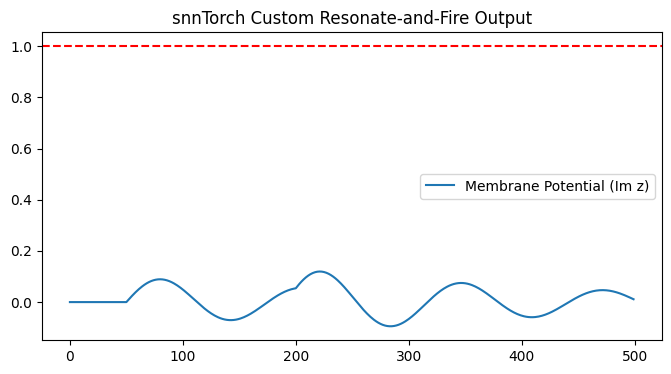

In [5]:
import torch
import torch.nn as nn
import snntorch as snn

class ResonateFire(nn.Module):
    """
    Resonate-and-Fire Neuron Model based on Izhikevich (2001).
    Equation: dz/dt = (b + iw)z + I
    """
    def __init__(self, b=-1.0, omega=10.0, threshold=1.0, dt=0.001):
        super().__init__()
        self.b = b
        self.omega = omega
        self.threshold = threshold
        self.dt = dt
        
        # Reset value (z resets to i, meaning x=0, y=1) 
        self.reset_x = 0.0
        self.reset_y = 0.0 # Paper figure 6 suggests reset to 0 relative to threshold shift,
                           # but text says reset to i. Let's stick to text: reset to i implies y=1?
                           # Actually, looking at Fig 5 bottom[cite: 187], the reset goes to a specific point.
                           # Let's parameterize it.
        
        self.spike_grad = snn.surrogate.fast_sigmoid() # Enable learning later

    def forward(self, input_current, mem_x=None, mem_y=None):
        """
        input_current: Input tensor (Time x Batch x ...)
        mem_x, mem_y: Previous states (Real and Imaginary parts)
        """
        
        # Initialize states if None
        if mem_x is None:
            mem_x = torch.zeros_like(input_current)
        if mem_y is None:
            mem_y = torch.zeros_like(input_current)
            
        # 1. Physics Step (Euler Integration)
        # Real part (x) corresponds to current-like variable [cite: 157]
        # Imag part (y) corresponds to voltage-like variable 
        
        dx = (self.b * mem_x - self.omega * mem_y + input_current) * self.dt
        dy = (self.omega * mem_x + self.b * mem_y) * self.dt
        
        mem_x_new = mem_x + dx
        mem_y_new = mem_y + dy
        
        # 2. Fire Step
        # Fire if Im(z) > threshold 
        spike = self.spike_grad(mem_y_new - self.threshold)
        
        # 3. Reset Step
        # If spike, reset logic. 
        # Note: Izhikevich resets z to 'i' (x=0, y=1). 
        # However, for continuous simulation, simple reset to 0 is often easier to stabilize first.
        # Let's try "Hard Reset to 0" for stability, or "Reset to i" if strictly following paper.
        
        reset_val_x = 0.0
        reset_val_y = 1.0 # The "Reset Value" in Fig 6 top seems to be slightly below threshold?
                          # Let's use 0 for now to match the "Rest" state behavior in simple terms.
        
        # Apply reset: if spike, state = reset_val, else state = new_val
        mem_x_next = (1 - spike) * mem_x_new + spike * reset_val_x
        mem_y_next = (1 - spike) * mem_y_new + spike * reset_val_y
        
        return spike, mem_x_next, mem_y_next

# --- Test the snnTorch Implementation ---
def test_snntorch_version():
    rf_neuron = ResonateFire(b=-5.0, omega=50.0, dt=0.001) # Tweaked params for visible oscillation
    
    # Create inputs (Batch size 1, 500 time steps)
    input_sim = torch.zeros(500, 1)
    input_sim[50] = 100.0 # Pulse 1
    input_sim[200] = 100.0 # Pulse 2
    
    spk_rec = []
    mem_y_rec = []
    
    mx, my = None, None
    
    for t in range(500):
        spk, mx, my = rf_neuron(input_sim[t], mx, my)
        spk_rec.append(spk)
        mem_y_rec.append(my)
        
    # Plot
    plt.figure(figsize=(8,4))
    plt.plot(torch.stack(mem_y_rec).detach().numpy(), label="Membrane Potential (Im z)")
    plt.axhline(1.0, linestyle="--", color="red")
    plt.title("snnTorch Custom Resonate-and-Fire Output")
    plt.legend()
    plt.show()

test_snntorch_version()